## ChatGPT Like

using TikToken

In [1]:
!pip install tiktoken -q
!pip install matplotlib -q 

In [2]:
import re
import matplotlib.pyplot as plt
import time
import os
import tiktoken
import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F

Hyperparameters

In [3]:
batch_size = 64 #64 # how many independent sequences will we process in parallel?
block_size = 128 #256 # what is the maximum context length for predictions?
max_iters = 2
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

#torch.manual_seed(1337)

In [4]:
torch.cuda.is_available()

True

## Set up

Read input + Tokenizer

In [5]:
with open('input-fr-tiktoken.txt', 'r', encoding='utf-8') as f:
    text = f.read()


In [6]:
tokenizers = tiktoken.get_encoding("gpt2") #gpt2 cl100k_base
vocab_size = tokenizers.n_vocab
print("\nvocab size: ", vocab_size)


vocab size:  50257


Sampling
```
te = text[20000:20400]
len(tokenizers.encode(te))
```


In [7]:
data = torch.tensor(tokenizers.encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:12])

n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

#train_data[:block_size+1]

torch.Size([145781390]) torch.int64
tensor([21944,   273, 25930,   628,   198, 35882,  1291,    85,   603,   293,
         1834,   390])


Model + utilities

In [8]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [9]:
backup_prefix = "saved-tiktoken-64batch-128block-"

def get_last_backup(backup_prefix):
    matching_files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith(backup_prefix)]
    if (len(matching_files)==0):
        return ""
    return max(matching_files, key=os.path.getmtime)

def extract_iteration_count_from(file_name):
    match = re.search(r'\d+(?=-ite)', file_name)
    if match:
        return int(match.group())
    else:
        return 0


In [10]:
def append_losses_to_file(filename, float_list):
    # open file in append mode
    with open(filename, 'a') as f:
        np.savetxt(f, float_list) #.numpy() 
    # close the file
    f.close()


## Instanciate model

Create Model

In [35]:
model = GPTLanguageModel()

Load weights from previous backup (if any)

In [36]:
last_backup_file = get_last_backup(backup_prefix)
last_backup_file 

'saved-tiktoken-64batch-128block-3000-ite-x_xx'

In [37]:
if (len(last_backup_file)!=0):
    model.load_state_dict(torch.load(last_backup_file))
    model.eval()
    print("Weights loaded from", last_backup_file)

Weights loaded from saved-tiktoken-64batch-128block-3000-ite-x_xx


Prepare model

In [38]:
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

49.337425 M parameters


## Run Training

In [39]:
max_iters = 1000

In [40]:
all_train_losses = []
all_val_losses = []
for iter in range(max_iters):
    start_time = time.time()

    # every once in a while evaluate the loss on train and val sets
    #if iter % eval_interval == 0 or iter == max_iters - 1:
    losses = estimate_loss()
    print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    
    all_train_losses.append(losses['train'])
    all_val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    print("Time : {:2f} seconds".format(time.time()-start_time))

step 0: train loss 2.7589, val loss 2.8211
Time : 14.703822 seconds
step 1: train loss 2.7734, val loss 2.8388
Time : 14.191895 seconds
step 2: train loss 2.7650, val loss 2.8292
Time : 14.192241 seconds
step 3: train loss 2.7766, val loss 2.8283
Time : 14.158944 seconds
step 4: train loss 2.7785, val loss 2.8385
Time : 14.080961 seconds
step 5: train loss 2.7680, val loss 2.8355
Time : 14.043661 seconds
step 6: train loss 2.7719, val loss 2.8300
Time : 14.101715 seconds
step 7: train loss 2.7800, val loss 2.8352
Time : 14.072532 seconds
step 8: train loss 2.7734, val loss 2.8381
Time : 14.024439 seconds
step 9: train loss 2.7734, val loss 2.8393
Time : 14.021602 seconds
step 10: train loss 2.7743, val loss 2.8393
Time : 14.255584 seconds
step 11: train loss 2.7717, val loss 2.8388
Time : 14.302429 seconds
step 12: train loss 2.7812, val loss 2.8414
Time : 14.113694 seconds
step 13: train loss 2.7744, val loss 2.8351
Time : 14.051122 seconds
step 14: train loss 2.7805, val loss 2.8408


step 119: train loss 2.7576, val loss 2.8199
Time : 14.100264 seconds
step 120: train loss 2.7566, val loss 2.8177
Time : 14.249090 seconds
step 121: train loss 2.7553, val loss 2.8128
Time : 14.310535 seconds
step 122: train loss 2.7540, val loss 2.8148
Time : 14.222354 seconds
step 123: train loss 2.7589, val loss 2.8150
Time : 14.125962 seconds
step 124: train loss 2.7523, val loss 2.8066
Time : 14.148922 seconds
step 125: train loss 2.7526, val loss 2.8132
Time : 14.138772 seconds
step 126: train loss 2.7480, val loss 2.8132
Time : 14.152767 seconds
step 127: train loss 2.7521, val loss 2.8164
Time : 14.158578 seconds
step 128: train loss 2.7540, val loss 2.8089
Time : 14.184744 seconds
step 129: train loss 2.7497, val loss 2.8150
Time : 14.327754 seconds
step 130: train loss 2.7514, val loss 2.8115
Time : 14.309767 seconds
step 131: train loss 2.7495, val loss 2.8165
Time : 14.123419 seconds
step 132: train loss 2.7438, val loss 2.8071
Time : 14.132457 seconds
step 133: train loss

step 237: train loss 2.7405, val loss 2.8043
Time : 14.096463 seconds
step 238: train loss 2.7430, val loss 2.8086
Time : 14.111556 seconds
step 239: train loss 2.7364, val loss 2.8051
Time : 14.362569 seconds
step 240: train loss 2.7400, val loss 2.8003
Time : 14.325330 seconds
step 241: train loss 2.7326, val loss 2.7981
Time : 14.135865 seconds
step 242: train loss 2.7323, val loss 2.7952
Time : 14.101346 seconds
step 243: train loss 2.7351, val loss 2.7969
Time : 14.151572 seconds
step 244: train loss 2.7318, val loss 2.7962
Time : 14.147619 seconds
step 245: train loss 2.7295, val loss 2.8024
Time : 14.103273 seconds
step 246: train loss 2.7376, val loss 2.8017
Time : 14.086688 seconds
step 247: train loss 2.7411, val loss 2.8065
Time : 14.246077 seconds
step 248: train loss 2.7375, val loss 2.8095
Time : 14.310622 seconds
step 249: train loss 2.7353, val loss 2.8010
Time : 14.196847 seconds
step 250: train loss 2.7400, val loss 2.8090
Time : 14.116480 seconds
step 251: train loss

step 355: train loss 2.7346, val loss 2.7864
Time : 14.146281 seconds
step 356: train loss 2.7207, val loss 2.7942
Time : 14.160025 seconds
step 357: train loss 2.7204, val loss 2.7884
Time : 14.235042 seconds
step 358: train loss 2.7266, val loss 2.7918
Time : 14.250906 seconds
step 359: train loss 2.7204, val loss 2.7867
Time : 14.168601 seconds
step 360: train loss 2.7301, val loss 2.7945
Time : 14.133622 seconds
step 361: train loss 2.7357, val loss 2.7991
Time : 14.166109 seconds
step 362: train loss 2.7215, val loss 2.7929
Time : 14.170804 seconds
step 363: train loss 2.7267, val loss 2.8007
Time : 14.144182 seconds
step 364: train loss 2.7249, val loss 2.7940
Time : 14.098826 seconds
step 365: train loss 2.7262, val loss 2.7874
Time : 14.142119 seconds
step 366: train loss 2.7300, val loss 2.7890
Time : 14.372785 seconds
step 367: train loss 2.7184, val loss 2.7803
Time : 14.337097 seconds
step 368: train loss 2.7187, val loss 2.7862
Time : 14.108524 seconds
step 369: train loss

step 473: train loss 2.7121, val loss 2.7851
Time : 14.155933 seconds
step 474: train loss 2.7168, val loss 2.7851
Time : 14.111325 seconds
step 475: train loss 2.7094, val loss 2.7857
Time : 14.193149 seconds
step 476: train loss 2.7236, val loss 2.7814
Time : 15.013141 seconds
step 477: train loss 2.7123, val loss 2.7846
Time : 14.439147 seconds
step 478: train loss 2.7162, val loss 2.7787
Time : 14.240706 seconds
step 479: train loss 2.7140, val loss 2.7836
Time : 14.131347 seconds
step 480: train loss 2.7091, val loss 2.7845
Time : 14.201088 seconds
step 481: train loss 2.7102, val loss 2.7785
Time : 14.172351 seconds
step 482: train loss 2.7169, val loss 2.7833
Time : 14.165928 seconds
step 483: train loss 2.7189, val loss 2.7844
Time : 14.169143 seconds
step 484: train loss 2.7187, val loss 2.7843
Time : 14.301481 seconds
step 485: train loss 2.7149, val loss 2.7818
Time : 14.313829 seconds
step 486: train loss 2.7178, val loss 2.7889
Time : 14.205790 seconds
step 487: train loss

step 591: train loss 2.7037, val loss 2.7635
Time : 14.181374 seconds
step 592: train loss 2.7059, val loss 2.7621
Time : 14.114610 seconds
step 593: train loss 2.7011, val loss 2.7722
Time : 14.114621 seconds
step 594: train loss 2.6980, val loss 2.7690
Time : 14.328017 seconds
step 595: train loss 2.7091, val loss 2.7793
Time : 14.357171 seconds
step 596: train loss 2.7181, val loss 2.7730
Time : 14.159525 seconds
step 597: train loss 2.7129, val loss 2.7700
Time : 14.096157 seconds
step 598: train loss 2.7149, val loss 2.7704
Time : 14.139545 seconds
step 599: train loss 2.7024, val loss 2.7797
Time : 14.190609 seconds
step 600: train loss 2.7136, val loss 2.7616
Time : 14.132528 seconds
step 601: train loss 2.7091, val loss 2.7775
Time : 14.105621 seconds
step 602: train loss 2.7092, val loss 2.7776
Time : 14.198645 seconds
step 603: train loss 2.7057, val loss 2.7704
Time : 14.321533 seconds
step 604: train loss 2.6948, val loss 2.7700
Time : 14.256386 seconds
step 605: train loss

step 709: train loss 2.6974, val loss 2.7637
Time : 14.143538 seconds
step 710: train loss 2.7003, val loss 2.7719
Time : 14.123603 seconds
step 711: train loss 2.6981, val loss 2.7656
Time : 14.139292 seconds
step 712: train loss 2.7032, val loss 2.7693
Time : 14.203907 seconds
step 713: train loss 2.7009, val loss 2.7671
Time : 14.275081 seconds
step 714: train loss 2.6994, val loss 2.7579
Time : 14.243869 seconds
step 715: train loss 2.6916, val loss 2.7671
Time : 14.163043 seconds
step 716: train loss 2.6885, val loss 2.7599
Time : 14.144562 seconds
step 717: train loss 2.6998, val loss 2.7638
Time : 14.175021 seconds
step 718: train loss 2.6955, val loss 2.7631
Time : 14.158701 seconds
step 719: train loss 2.7016, val loss 2.7745
Time : 14.115753 seconds
step 720: train loss 2.6949, val loss 2.7687
Time : 14.142457 seconds
step 721: train loss 2.6974, val loss 2.7639
Time : 14.384966 seconds
step 722: train loss 2.6962, val loss 2.7651
Time : 14.369500 seconds
step 723: train loss

step 827: train loss 2.6871, val loss 2.7522
Time : 14.183056 seconds
step 828: train loss 2.6888, val loss 2.7544
Time : 14.154985 seconds
step 829: train loss 2.6859, val loss 2.7620
Time : 14.112700 seconds
step 830: train loss 2.6850, val loss 2.7543
Time : 14.109104 seconds
step 831: train loss 2.6849, val loss 2.7518
Time : 14.302812 seconds
step 832: train loss 2.6801, val loss 2.7587
Time : 14.304141 seconds
step 833: train loss 2.6923, val loss 2.7556
Time : 14.126079 seconds
step 834: train loss 2.6894, val loss 2.7651
Time : 14.123835 seconds
step 835: train loss 2.6879, val loss 2.7594
Time : 14.144480 seconds
step 836: train loss 2.6846, val loss 2.7590
Time : 14.134665 seconds
step 837: train loss 2.6935, val loss 2.7560
Time : 14.146576 seconds
step 838: train loss 2.6884, val loss 2.7510
Time : 14.147535 seconds
step 839: train loss 2.6913, val loss 2.7499
Time : 14.234916 seconds
step 840: train loss 2.6854, val loss 2.7521
Time : 14.286472 seconds
step 841: train loss

step 945: train loss 2.6750, val loss 2.7505
Time : 14.159231 seconds
step 946: train loss 2.6765, val loss 2.7469
Time : 14.153757 seconds
step 947: train loss 2.6794, val loss 2.7519
Time : 14.113166 seconds
step 948: train loss 2.6845, val loss 2.7464
Time : 14.118094 seconds
step 949: train loss 2.6792, val loss 2.7559
Time : 14.270528 seconds
step 950: train loss 2.6825, val loss 2.7484
Time : 14.365271 seconds
step 951: train loss 2.6823, val loss 2.7520
Time : 14.247933 seconds
step 952: train loss 2.6793, val loss 2.7483
Time : 14.109315 seconds
step 953: train loss 2.6779, val loss 2.7503
Time : 14.183018 seconds
step 954: train loss 2.6814, val loss 2.7480
Time : 14.174367 seconds
step 955: train loss 2.6789, val loss 2.7559
Time : 14.157983 seconds
step 956: train loss 2.6882, val loss 2.7495
Time : 14.114030 seconds
step 957: train loss 2.6818, val loss 2.7507
Time : 14.137438 seconds
step 958: train loss 2.6762, val loss 2.7463
Time : 14.322346 seconds
step 959: train loss

Create samples

In [41]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)

print(tokenizers.decode(m.generate(context, max_new_tokens=250)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


! dis Moule Picautris !… C’est encore la première chose ! Je ne parle pas en ce moment que le Victor n’est pas un homme que Favras ; qui devient glissent à terre. La tyrannie a été si brave, elle est partie, j’avais des objets à ma bonneauxse…

Schmisse Écoutez, qui va ne si, sursis de se faire effacer de M. le jette immoral à l’État. Je rappelle le procureur Vent-moi bien et jeune fille



Grand bien extraordinaire, bien des reçus et les montagnes tranquilles, mais le voilà tout, chèreomaîquées, jusqu’à sa famille des hommes, et après toute mon absence il m’attendrait. Il y avait dans la vallée de M. bal. Deux endurzes distroite étaient épermés pour moi, en feuillire les ch


In [42]:
context = torch.tensor([tokenizers.encode("Sous un soleil, ")], dtype=torch.long, device=device)

print(tokenizers.decode(m.generate(context, max_new_tokens=250)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


Sous un soleil, était lié, longueurs des vieillards. Je dormais debout. Tout en deux av rubans, et contaient un pavillon retentissait dans la rubitation, j’y fis certaines gens qui me paraissaient ses lignoirs ardeurs à cette fenêtre ou du silence. Lucien Hector ne se détachait sa part la première remercitive de lui, fit jusqu’à l’éternité du cadavre de l’honneur. Je n’étais pas très cher, Pierre.

Clérait, bien encore après le doux du sang qui sortait avec résultat ses rayons infimales, entourait le ciel dans la rivière ; celui-ci, — et, dans le bois à la colline, à l’ordonafouchon, une troisième ou large voiture dans laquelle ils un fort à remplir des circonstances d


Save results

In [43]:
last_iteration = extract_iteration_count_from(last_backup_file)
current_iteration = last_iteration + max_iters
current_save = "{}{}-ite-x_xx".format(backup_prefix, current_iteration)
print("Save in:",current_save)

Save in: saved-tiktoken-64batch-128block-4000-ite-x_xx


In [44]:
torch.save(model.state_dict(), current_save)

append_losses_to_file("saved-tiktoken-train-losses.txt", all_train_losses)
append_losses_to_file("saved-tiktoken-val-losses.txt", all_val_losses)

## Graphs

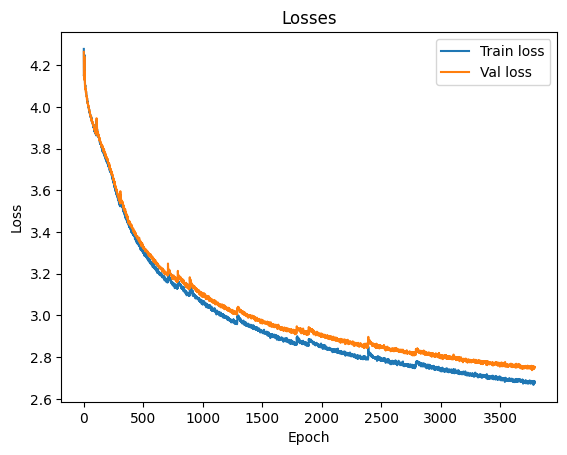

In [45]:
# load array from file and convert to PyTorch tensor
train_losses = np.loadtxt('saved-tiktoken-train-losses.txt')
val_losses = np.loadtxt('saved-tiktoken-val-losses.txt')
#my_tensor = torch.from_numpy(my_array)


def plot_losses(losses1, losses2):
    # create a new figure
    plt.figure()

    # plot the first series of losses
    plt.plot(losses1, label='Train loss')

    # plot the second series of losses
    plt.plot(losses2, label='Val loss')

    # add labels and title to the plot
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses')

    # add a legend to the plot
    plt.legend()

    # display the plot
    plt.show()

plot_losses(train_losses, val_losses)

## Clean-up

In [46]:
del m
del model
del optimizer

torch.cuda.empty_cache()

.